In [ ]:
# Constant
HEPA_FILE_PATH = "hepatitis.data"
DIAB_FILE_PATH = "messidor_features.arff"

MIN_K = 1
MAX_K = 25

EUCLIDEAN = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
MANHATTAN = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
HAMMING = lambda x1, x2: np.count_nonzero(x1 - x2, axis=-1)

TEST_SIZE_DEFAULT = 0.5
VAL_SIZE_DEFAULT = 0.2
RANDOM_STATE_DEFAULT = 42

# Task 1: Acquire, preprocess, and analyze the data

### Download dataset

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

--2022-10-05 20:41:25--  http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7545 (7.4K) [application/x-httpd-php]
Saving to: ‘hepatitis.data.2’

hepatitis.data.2    100%[===================>]   7.37K  --.-KB/s    in 0s      

2022-10-05 20:41:25 (653 MB/s) - ‘hepatitis.data.2’ saved [7545/7545]

--2022-10-05 20:41:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117224 (114K) [application/x-httpd-php]
Saving to: ‘messidor_features.arff.2’

messidor_features.a 100%[===================>] 114.4

In [ ]:
!pip install -Uqq ipdb
import ipdb

### Define Dataset Manager

Here we define dataset manager class to download, preprocess, and analyse data. Further, we clean the data (e.g. remove missing and malformed data) in this class. Last but not least, since the data contains both categorical and numerical features, we convert numerical features to categorical features, and use one-hot encoding to encode the features.

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import copy

class DatasetManager:


    """ Initialize """

    def __init__(self, 
                 file_url,
                 y_col,
                 test_size=TEST_SIZE_DEFAULT,
                 val_size=VAL_SIZE_DEFAULT,
                 random_state=RANDOM_STATE_DEFAULT,
                 column_names=None,
                 over_sample=False,
                 skiprows=None,
                 feature_callback=None):
        """
        Constructor dataset manager class.

        :param file_url:         File URL.
        :param y_col:            Column of label in dataframe.
        :param test_size:        Test set size.
        :param val_size:         Validation set size.
        :param random_state:     Random state to split train and test dataset.
        :param over_sample:      Whether to perform over sampling.
        :param skiprows:         Skip rows in the dataframe.
        :param feature_callback: Callback to preprocess features with customisations.
        """
        df = pd.read_csv(file_url,
                         skiprows=skiprows,
                         header=None)
        
        self._preprocess_data(df, y_col, 
                              test_size, 
                              val_size,
                              over_sample,
                              random_state,
                              feature_callback)


    """ Getters """

    @property
    def train_data(self):
        return self._x_train, self._y_train

    @property
    def val_data(self):
        return self._x_val, self._y_val

    @property
    def test_data(self):
        return self._x_test, self._y_test

    @property
    def features(self):
        return self._x

    @property
    def labels(self):
        return self._y


    """ Public methods """

    def analyse_data_count(self, idx, 
                           bins=None, 
                           xtick_labels=None,
                           title=None):
        """
        Analyse data count.

        :param idx:          Index of data.
        :param bins:         Bin count. For binary data, bins should be "None".
        :param xtick_labels: Custom xtick labels.
        :param title:        Title of the plot.
        """

        assert self._updated_df is not None

        value_counts = self._updated_df.iloc[:, idx].value_counts(bins=bins, 
                                                                  sort=False)
        print(value_counts)
        value_counts.plot(kind='bar', 
                          title=title)
        
        ax = plt.gca()
        ax.tick_params(labelrotation=45)
        if xtick_labels is not None:
            ax.set_xticklabels(xtick_labels)
        
        for i, v in enumerate(value_counts.values):
            plt.text(i-0.1, v, str(v), color='red', fontweight='bold')
        plt.ylabel("Data Count")


    def analyse_feature_importance(self, x, y,
                                   title=None):
        """
        Analyse feature importance using random forest classifier.

        :param x:     Features.
        :param y:     Labels.
        :param title: Title of the plot.
        """

        feature_names = list(np.arange(x.shape[1]))
        forest = RandomForestClassifier(random_state=0)
        forest.fit(x, y)

        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

        forest_importances = pd.Series(importances, index=feature_names)

        fig, ax = plt.subplots(figsize=(8, 5))
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title(title)
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()


    """ Private methods """
    
    def _preprocess_data(self, df, y_col,
                         test_size, val_size,
                         over_sample,
                         random_state,
                         feature_callback):

        # Remove missing data
        self._updated_df = df[~df.isin([np.nan, np.inf, -np.inf, "?"]).any(1)]
        self._updated_df = self._updated_df.astype(float)

        print("Original data shape: {}".format(df.shape))
        print("Updated data shape after removing malformed data: {}".format(self._updated_df.shape))

        updated_df_cp = copy.deepcopy(self._updated_df)

        # Convert to numpy type
        df_np = updated_df_cp if type(updated_df_cp).__module__ == np.__name__ else updated_df_cp.to_numpy()

        mask = np.ones(df_np.shape[1], bool)
        mask[[y_col]] = False
        self._x, self._y = df_np[:,mask], df_np[:,~mask]

        # Custom preprocessing features
        if feature_callback is not None:
            x, y = feature_callback(copy.deepcopy(self._x), 
                                    copy.deepcopy(self._y))

        y = y[:,0]
        y = y.astype(int)
        print("Updated data shape after custom processing: {}".format(x.shape))

        # Split test data
        x_tmp, self._x_test, y_tmp, self._y_test = train_test_split(x, y, 
                                                                    test_size=test_size,
                                                                    shuffle=True,
                                                                    random_state=random_state)
        
        # Split train and validation data
        self._x_train, self._x_val, self._y_train, self._y_val = train_test_split(x_tmp, y_tmp, 
                                                                                  test_size=val_size,
                                                                                  shuffle=True,
                                                                                  random_state=random_state)
        
        # Over sample on the train data
        if over_sample:
            
            print(self._x_train.shape)
            print(self._y_train.shape)

            over_sampler = RandomOverSampler(sampling_strategy='minority')
            self._x_train, self._y_train = over_sampler.fit_resample(self._x_train, self._y_train)
        
        print("x shape: {}, y shape: {}".format(x.shape, y.shape))
        print("x_train shape: {}, y_train shape: {}".format(self._x_train.shape, self._y_train.shape))
        print("x_val shape: {}, y_val shape: {}".format(self._x_val.shape, self._y_val.shape))
        print("x_test shape: {}, y_test shape: {}".format(self._x_test.shape, self._y_test.shape))

### Analyse Data

##### Hepatitis (Creative Point: Over-sample the imbalanced data)

First instantiate dataset manager

In [ ]:
def hepa_callback(x, y):

    """
    1. Since most of the features are categorical features, 
    we will transform numerical to categorical features,
    because categorical features does not have numerical magnitude (e.g. 1 > 0)
    2. Use one-hot encoding to encode the features
    """

    """
    replace_dict:
    keys: column index of numerical features
    values: bins to convert to categorical features
    """
    replace_dict = {
        0: [10, 20, 30, 40, 50, 60, 70, 80], # AGE
        13: [0.39, 0.80, 1.20, 2.00, 3.00, 4.00], # BILIRUBIN
        14: [33, 80, 120, 160, 200, 250], # ALK PHOSPHATE
        15: [13, 100, 200, 300, 400, 500], # SGOT
        16: [2.1, 3.0, 3.8, 4.5, 5.0, 6.0], # ALBUMIN
        17: [10, 20, 30, 40, 50, 60, 70, 80, 90] # PROTIME
    }

    df = pd.DataFrame(x)
    print("Previous dataframe:")
    print(df)

    # Convert numerical to categorical features
    for idx, bins in replace_dict.items():

        print("Index: {}, bins: {}".format(idx, bins))
        replace_df = pd.cut(df.iloc[:,idx],
                            bins=bins, 
                            labels=False)
        replace_df = replace_df.astype(float)
        df.loc[:,idx] = replace_df
        print("Replace dataframe:")
        print(replace_df)

    print("After dataframe:")
    print(df)

    # One hot encoding
    x_encoder = OneHotEncoder(sparse=False)
    x = x_encoder.fit_transform(df)

    # Make sure y is 0 and 1
    y -= 1

    return x, y

In [ ]:
hepa_dataset = DatasetManager(file_url=HEPA_FILE_PATH, 
                              y_col=0,
                              over_sample=True,
                              feature_callback=hepa_callback)

Original data shape: (155, 20)
Updated data shape after removing malformed data: (80, 20)
Previous dataframe:
      0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0   34.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  0.9   
1   39.0  1.0  1.0  1.0  2.0  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  1.3   
2   32.0  1.0  2.0  1.0  1.0  2.0  2.0  2.0  1.0  2.0  1.0  2.0  2.0  1.0   
3   41.0  1.0  2.0  1.0  1.0  2.0  2.0  2.0  1.0  2.0  2.0  2.0  2.0  0.9   
4   30.0  1.0  2.0  2.0  1.0  2.0  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.2   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
75  45.0  1.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  1.3   
76  49.0  1.0  1.0  2.0  1.0  1.0  2.0  2.0  2.0  1.0  1.0  2.0  2.0  1.4   
77  31.0  1.0  1.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  1.2   
78  53.0  2.0  1.0  2.0  1.0  2.0  2.0  2.0  2.0  1.0  1.0  2.0  1.0  1.5   
79  43.0  1.0  2.0  2.0  1.0  2.0  2.0  2.0

Create training set, validation set, and test set

In [ ]:

x_hepa_train, y_hepa_train = hepa_dataset.train_data
x_hepa_val, y_hepa_val = hepa_dataset.val_data
x_hepa_test, y_hepa_test = hepa_dataset.test_data

Then analyse features after removing malformed data

2.0    67
1.0    13
Name: 0, dtype: int64


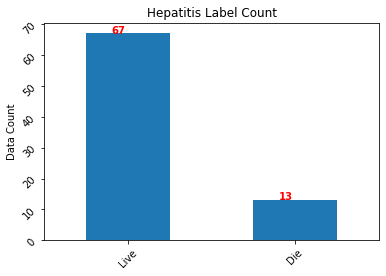

In [ ]:
hepa_dataset.analyse_data_count(idx=0, 
                                xtick_labels=["Live", "Die"],
                                title="Hepatitis Label Count")

(9.999, 20.0]     1
(20.0, 30.0]     15
(30.0, 40.0]     30
(40.0, 50.0]     18
(50.0, 60.0]     11
(60.0, 70.0]      4
(70.0, 80.0]      1
Name: 1, dtype: int64


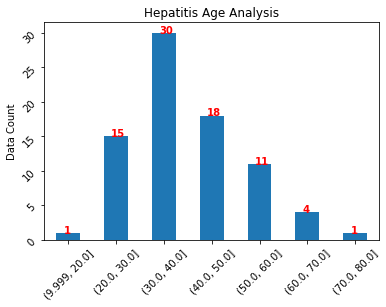

In [ ]:
hepa_dataset.analyse_data_count(idx=1,
                                bins=[10, 20, 30, 40, 50, 60, 70, 80],
                                title="Hepatitis Age Analysis")

1.0    69
2.0    11
Name: 2, dtype: int64


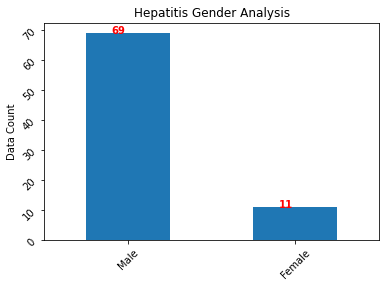

In [ ]:
hepa_dataset.analyse_data_count(idx=2,
                                xtick_labels=["Male", "Female"],
                                title="Hepatitis Gender Analysis")

Analysis feature importance

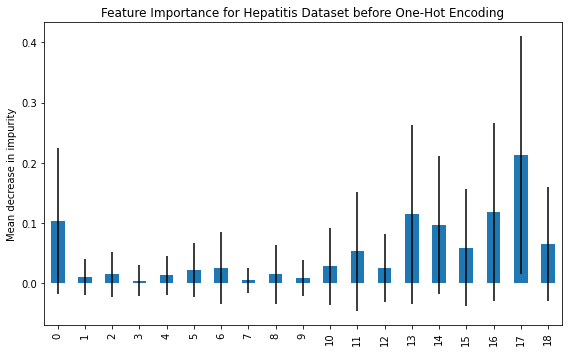

In [ ]:
x = hepa_dataset.features
y = copy.deepcopy(hepa_dataset.labels)
y = y[:,0]
y = y.astype(int)
y = y - 1

hepa_dataset.analyse_feature_importance(x=x, y=y,
                                        title="Feature Importance for Hepatitis Dataset before One-Hot Encoding")

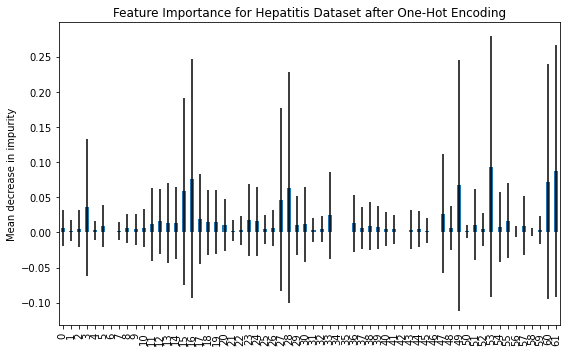

In [ ]:
hepa_dataset.analyse_feature_importance(x=x_hepa_train, y=y_hepa_train,
                                        title="Feature Importance for Hepatitis Dataset after One-Hot Encoding")

##### Diabetis (Creative Point: Feature Scaling)

First instantiate dataset manager

In [ ]:
from sklearn.preprocessing import StandardScaler

def diab_callback(x, y):

    """
    Since most of the features are numerical features, 
    we will standardize the features into the same scale
    """

    print("Before: {}".format(x[:10]))
    scaler = StandardScaler()
    updated_x = scaler.fit_transform(x)
    print("After: {}".format(updated_x[:10]))

    return updated_x, y

In [ ]:
diab_dataset = DatasetManager(file_url=DIAB_FILE_PATH, 
                              y_col=19,
                              skiprows=list(range(24)),
                              feature_callback=diab_callback)

Original data shape: (1151, 20)
Updated data shape after removing malformed data: (1151, 20)
Before: [[1.0000000e+00 1.0000000e+00 2.2000000e+01 2.2000000e+01 2.2000000e+01
  1.9000000e+01 1.8000000e+01 1.4000000e+01 4.9895756e+01 1.7775994e+01
  5.2709200e+00 7.7176100e-01 1.8632000e-02 6.8640000e-03 3.9230000e-03
  3.9230000e-03 4.8690300e-01 1.0002500e-01 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 2.4000000e+01 2.4000000e+01 2.2000000e+01
  1.8000000e+01 1.6000000e+01 1.3000000e+01 5.7709936e+01 2.3799994e+01
  3.3254230e+00 2.3418500e-01 3.9030000e-03 3.9030000e-03 3.9030000e-03
  3.9030000e-03 5.2090800e-01 1.4441400e-01 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 6.2000000e+01 6.0000000e+01 5.9000000e+01
  5.4000000e+01 4.7000000e+01 3.3000000e+01 5.5831441e+01 2.7993933e+01
  1.2687485e+01 4.8522820e+00 1.3938890e+00 3.7325200e-01 4.1817000e-02
  7.7440000e-03 5.3090400e-01 1.2854800e-01 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 5.5000000e+01 5.3000000e+01 5.3000000e+01
  

Create training set, validation set, and test set

In [ ]:
x_diab_train, y_diab_train = diab_dataset.train_data
x_diab_val, y_diab_val = diab_dataset.val_data
x_diab_test, y_diab_test = diab_dataset.test_data

Then analyse features after removing malformed data

TODO:

0.0    540
1.0    611
Name: 19, dtype: int64


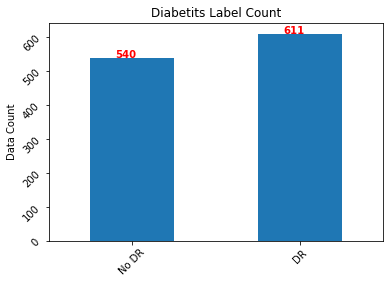

In [ ]:
diab_dataset.analyse_data_count(idx=19, 
                                xtick_labels=["No DR", "DR"],
                                title="Diabetits Label Count")

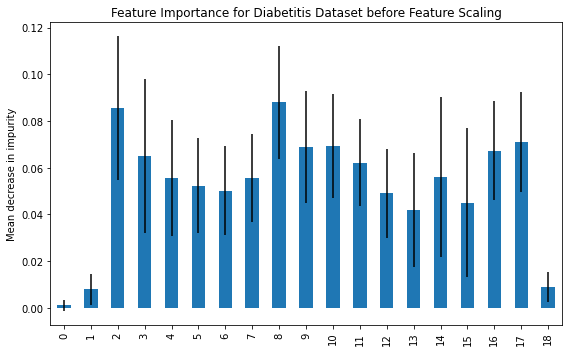

In [ ]:
x = diab_dataset.features
y = copy.deepcopy(diab_dataset.labels)
y = y[:,0]
y = y.astype(int)
y = y - 1

diab_dataset.analyse_feature_importance(x=x, y=y,
                                        title="Feature Importance for Diabetitis Dataset before Feature Scaling")

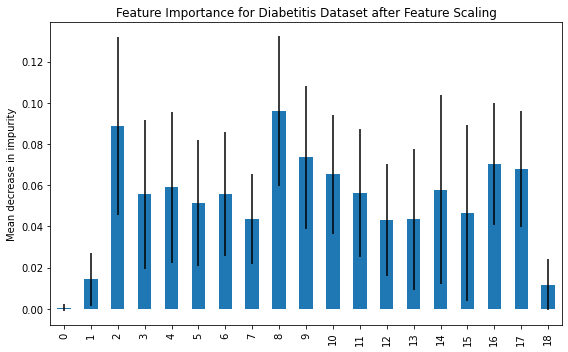

In [ ]:
diab_dataset.analyse_feature_importance(x=x_diab_train, y=y_diab_train,
                                        title="Feature Importance for Diabetitis Dataset after Feature Scaling")

# Task 2: Implementing KNN and DT

In [ ]:
# Note: 

# Use for hepatitis:
# x_hepa_train, y_hepa_train
# x_hepa_val, y_hepa_val
# x_hepa_test, y_hepa_test

# Use for diabetits:
# x_diab_train, y_diab_train
# x_diab_val, y_diab_val
# x_diab_test, y_diab_test

## KNN

### Vanilla KNN

In [ ]:
class KNN:


    """ Initialize """

    def __init__(self, 
                 K=1, 
                 dist_fn=EUCLIDEAN):
        self._dist_fn = dist_fn
        self._K = K
    

    """ Public methods """

    def fit(self, x, y):
        
        ''' Store the training data using this method as it is a lazy learner'''
        self._x = x
        self._y = y
        self._C = int(np.max(y) + 1)
        
        return self
    

    def predict(self, x_test):
        
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        
        # calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        # self.x is in shape (100, 2), x_test is in shape (50, 2)
        # self.x[None, :, :] is in shape (1, 100, 2), and x_test[:,None,:] is in shape (50, 1, 2)
        # result: (x_test.shape[0], self.x.shape[0])

        x1 = self._x[None,:,:]
        x2 = x_test[:,None,:]

        print("x1 shape: {}, x2 shape: {}".format(x1.shape, x2.shape))
        distances = self._dist_fn(x1, x2)
        
        # ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self._K), dtype=int)
        
        # ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self._C))
        
        for i in range(num_test):
            
            # Label index based on sorted distance
            knns[i,:] = np.argsort(distances[i])[:self._K]

            # ipdb.set_trace(context=15)

            # Counts the number of instances of each class in the K-closest training samples
            y_prob[i,:] = np.bincount(self._y[knns[i,:]], minlength=self._C)
        
        # Divide by K to get a probability distribution
        y_prob /= self._K
        
        return y_prob, knns

### Weighted KNN (Creative Point)

In [ ]:
class WeightedKNN(KNN):


    """ Initialize """

    def __init__(self, 
                 K=1, 
                 dist_fn=EUCLIDEAN):
        super().__init__(K=K, 
                         dist_fn=dist_fn)
        

    """ Public methods """

    def fit(self, x, y):
        return super().fit(x, y)


    def predict(self, x_test):
        
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        
        # calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        # self.x is in shape (100, 2), x_test is in shape (50, 2)
        # self.x[None, :, :] is in shape (1, 100, 2), and x_test[:,None,:] is in shape (50, 1, 2)
        # result: (x_test.shape[0], self.x.shape[0])

        x1 = self._x[None,:,:]
        x2 = x_test[:,None,:]

        y = np.squeeze(self._y)

        print("x1 shape: {}, x2 shape: {}".format(x1.shape, x2.shape))
        distances = self._dist_fn(x1, x2)

        # Weights (add 1e-10 to avoid divide by zero)
        weights = 1. / (1e-10 + distances)

        # ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self._K), dtype=int)
        
        # ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self._C))

        for i in range(num_test):
            
            # Label index based on sorted distance
            label_idx = np.argsort(distances[i])[:self._K]
            knns[i,:] = label_idx

            # Weights of the corresponding label index
            knns_weights = weights[i][label_idx]
            weights_sum = np.sum(knns_weights)

            # Weighted KNN
            sum_prob = 0
            for label in np.arange(self._C):

                # 1 / sum(knns_weights) * sum(label_weights_of_given_class)
                mask = y[label_idx] == np.full((y[label_idx]).shape, label)
                prob = np.sum(mask * knns_weights) / weights_sum
                y_prob[i,label] = prob
                sum_prob += prob

            print("Sum of probs: {}".format(sum_prob))
        
        return y_prob, knns

## DT

Cost Functions

In [ ]:
# misclassification
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

# entropy
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              
    return -np.sum(class_probs * np.log2(class_probs))

# gini index
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))


Node

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    
        self.left = None                                    
        self.right = None                                   
        self.split_feature = None                           
        self.split_value = None                        
        if parent:
            self.depth = parent.depth + 1                   
            self.num_classes = parent.num_classes        
            self.data = parent.data                         
            self.labels = parent.labels                     
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes)
            self.class_prob = class_prob / np.sum(class_prob)

The DecisionTree Class

In [ ]:
class DecisionTree:
    
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      
        self.root = None                
        self.cost_fn = cost_fn          
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances

    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels) + 1
        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        self._fit_tree(self.root)
        return self

    def predict(self, data_test):
        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        for n, x in enumerate(data_test):
            node = self.root
            #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
            class_probs[n,:] = node.class_prob
        return class_probs

    def get_feature_importance(self):

        result = []
        node_queue = []
    
        # Enqueue Root and initialize height
        node_queue.append(self.root)
    
        while(len(node_queue) > 0):

            node = node_queue.pop(0)
            feature_importance = node.split_feature
            if feature_importance is not None:
                result.append(feature_importance)
                print("Feature importance: {}".format(feature_importance))
    
            # Enqueue left child
            if node.left is not None:
                node_queue.append(node.left)
    
            # Enqueue right child
            if node.right is not None:
                node_queue.append(node.right)

        return result


    def _greedy_test(self, node, cost_fn):
        
        best_cost = np.inf
        best_feature, best_value = None, None
        num_instances, num_features = node.data.shape
        data_sorted = np.sort(node.data[node.data_indices],axis=0)
        test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
        
        for f in range(num_features):
            data_f = node.data[node.data_indices, f]
            for test in test_candidates[:,f]:
                left_indices = node.data_indices[data_f <= test]
                right_indices = node.data_indices[data_f > test]
                if len(left_indices) == 0 or len(right_indices) == 0:                
                    continue                 
                
                left_cost = cost_fn(node.labels[left_indices])
                right_cost = cost_fn(node.labels[right_indices])
                
                num_left, num_right = left_indices.shape[0], right_indices.shape[0]
                cost = (num_left * left_cost + num_right * right_cost) / num_instances

                if cost < best_cost:
                    best_cost = cost
                    best_feature = f
                    best_value = test

        return best_cost, best_feature, best_value

    def _fit_tree(self, node):
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        cost, split_feature, split_value = self._greedy_test(node, self.cost_fn)
        if np.isinf(cost):
            return
        test = node.data[node.data_indices,split_feature] <= split_value
        node.split_feature = split_feature
        node.split_value = split_value
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[np.logical_not(test)], node)
        self._fit_tree(left)
        self._fit_tree(right)
        node.left = left
        node.right = right

# Task 3: Running experiments

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sn


class EvaluationUtils:

    """ Utility class to evaluate models """

    @staticmethod
    def calculate_accuracy(y_pred, y_true):
        return np.mean(np.abs(y_pred - y_true) < 1e-10)


    @staticmethod
    def calculate_bce_loss(y_probs, y_true):
        return np.mean(-1 * (y_true * np.log(y_probs + 1e-10) + (1 - y_true) * np.log(1 - y_probs + 1e-10)))


    @staticmethod
    def calculate_roc_auc(y_probs, y_true):
        return roc_auc_score(y_true, y_probs)


    @staticmethod
    def calculate_pr_auc(y_probs, y_true):
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        return auc(recall, precision)

    
    @staticmethod
    def plot_confusion_matrix(y_pred, y_true):
        mat = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(mat)
        plt.title("Confusion Matrix")
        sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')

    
    @staticmethod
    def plot_roc_curve(y_probs, y_true):

        no_skill = [0 for _ in range(len(y_true))]
        ns_fpr, ns_tpr, _ = roc_curve(y_true, no_skill)
        lr_fpr, lr_tpr, _ = roc_curve(y_true, y_probs)

        ns_auc = roc_auc_score(y_true, no_skill)
        lr_auc = roc_auc_score(y_true, y_probs)

        plt.title("ROC")
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label='Proposed Model')
        plt.grid(linewidth=0.5)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.show()


    @staticmethod
    def plot_pr_curve(y_probs, y_true):

        precision, recall, _ = precision_recall_curve(y_true, y_probs)

        plt.title("PR")
        plt.plot(recall, precision, marker='.', label='Proposed Model')
        plt.grid(linewidth=0.5)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

## KNN

### Hepatis (Distance: Hamming)

In [ ]:
best_knn_hepa_loss = float('inf')
best_knn_hepa_k = None
best_knn_hepa_model = None

knn_hepa_loss_list = [] # Loss on validation set
knn_hepa_acc_list = [] # Accuracy on validation set

for k in range(MIN_K, MAX_K + 1):

    vanilla_knn = KNN(K=k, dist_fn=HAMMING)
    y_prob, _ = vanilla_knn.fit(x_hepa_train, y_hepa_train).predict(x_hepa_val)
    
    print("K: {}, y prob: {}".format(k, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_hepa_val)
    knn_hepa_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_hepa_val)
    knn_hepa_acc_list.append(acc)

    print("K: {}, Validation loss: {}, acc: {}".format(k, loss, acc))

    if loss < best_knn_hepa_loss:
        best_knn_hepa_loss = loss
        best_knn_hepa_k = k
        best_knn_hepa_model = vanilla_knn

print("Best loss: {}".format(best_knn_hepa_loss))
print("Best K: {}".format(best_knn_hepa_k))

x1 shape: (1, 54, 62), x2 shape: (8, 1, 62)
K: 1, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
K: 1, Validation loss: 5.756462732410115, acc: 0.75
x1 shape: (1, 54, 62), x2 shape: (8, 1, 62)
K: 2, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
K: 2, Validation loss: 5.756462732410115, acc: 0.75
x1 shape: (1, 54, 62), x2 shape: (8, 1, 62)
K: 3, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
K: 3, Validation loss: 5.756462732410115, acc: 0.75
x1 shape: (1, 54, 62), x2 shape: (8, 1, 62)
K: 4, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
K: 4, Validation loss: 5.756462732410115, acc: 0.75
x1 shape: (1, 54, 62), x2 shape: (8, 1, 62)
K: 5, y prob: [[0.2 0.8]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]]
K: 5, Validation loss: 5.784355676321266, acc: 0.75
x1 shape: (1, 54, 62), x2 shape: (8, 1, 62)
K: 6, y prob: [[0.3333333

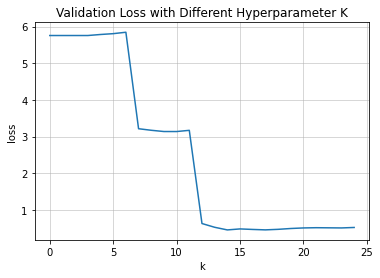

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.title('Validation Loss with Different Hyperparameter K')
plt.plot(knn_hepa_loss_list)
plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('k')
plt.show()

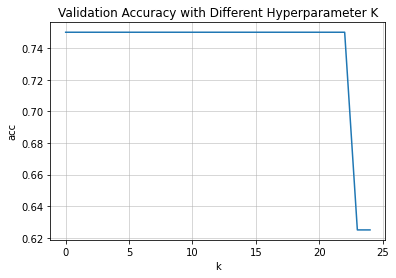

In [ ]:
plt.title('Validation Accuracy with Different Hyperparameter K')
plt.plot(knn_hepa_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('k')
plt.show()

TODO: in the report: Redundant to re-train the model. Directly save the best model, and predict it directly

In [ ]:
y_prob, _ = best_knn_hepa_model.predict(x_hepa_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_hepa_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_hepa_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_hepa_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_hepa_test)
print("AUPRC: {}".format(pr))

x1 shape: (1, 54, 62), x2 shape: (40, 1, 62)
Loss: 0.3272854396488565
Accuracy: 0.85
AUROC: 0.9264069264069263
AUPRC: 0.9840077095651223


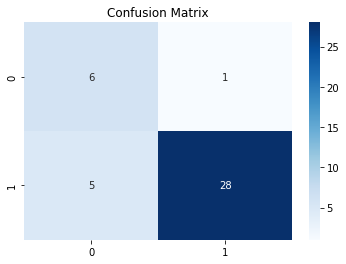

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_hepa_test)

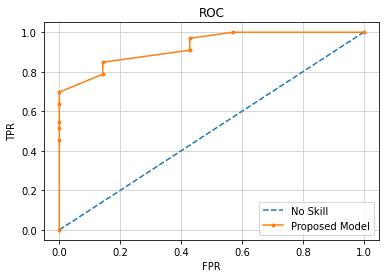

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_hepa_test)

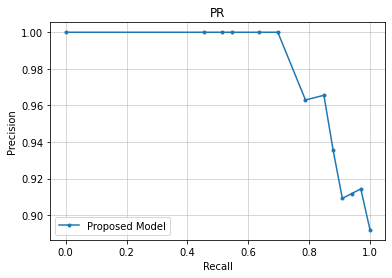

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_hepa_test)

x1 shape: (1, 67, 2), x2 shape: (40000, 1, 2)


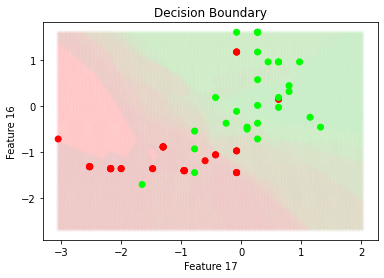

In [ ]:
# Hepatitis feature before one-hot encoding
hepa_x, hepa_y = hepa_dataset.features, hepa_dataset.labels

# Choose two features
hepa_x = hepa_x[:,[16,17]]

# Standardization
scaler = StandardScaler()
hepa_x = scaler.fit_transform(hepa_x)

# Over sampling
over_sampler = RandomOverSampler(sampling_strategy='minority')
hepa_x, hepa_y = over_sampler.fit_resample(hepa_x, hepa_y)

hepa_y -= 1
hepa_y = hepa_y.astype(int)

# Train test split
hepa_x_train, _, hepa_y_train, _ = train_test_split(hepa_x, hepa_y, 
                                                    test_size=TEST_SIZE_DEFAULT,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE_DEFAULT)

x0v = np.linspace(np.min(hepa_x[:,0]), np.max(hepa_x[:,0]), 200)
x1v = np.linspace(np.min(hepa_x[:,1]), np.max(hepa_x[:,1]), 200)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

hepa_knn = KNN(K=best_knn_hepa_k, dist_fn=EUCLIDEAN)
y_all, _ = hepa_knn.fit(hepa_x_train, hepa_y_train).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((hepa_y_train.shape[0], 3))
y_train_prob[np.arange(hepa_y_train.shape[0]), hepa_y_train] = 1

plt.scatter(hepa_x_train[:,0], hepa_x_train[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 16')
plt.xlabel('Feature 17')
plt.title("Decision Boundary")
plt.show()

### Diabetis

##### Vanilla KNN (Distance: Euclidean)

In [ ]:
best_vanilla_knn_diab_loss = float('inf')
best_vanilla_knn_diab_k = None
best_vanilla_knn_diab_model = None

vanilla_knn_diab_loss_list = [] # Loss on validation set
vanilla_knn_diab_acc_list = [] # Accuracy on validation set
 
for k in range(MIN_K, MAX_K + 1):

    vanilla_knn = KNN(K=k, dist_fn=EUCLIDEAN)
    y_prob, _ = vanilla_knn.fit(x_diab_train, y_diab_train).predict(x_diab_val)
    
    print("K: {}, y prob: {}".format(k, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_val)
    vanilla_knn_diab_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_val)
    vanilla_knn_diab_acc_list.append(acc)

    print("K: {}, Validation loss: {}, acc: {}".format(k, loss, acc))

    if loss < best_vanilla_knn_diab_loss:
        best_vanilla_knn_diab_loss = loss
        best_vanilla_knn_diab_k = k
        best_vanilla_knn_diab_model = vanilla_knn

print("Best loss: {}".format(best_vanilla_knn_diab_loss))
print("Best K: {}".format(best_vanilla_knn_diab_k))

x1 shape: (1, 460, 19), x2 shape: (115, 1, 19)
K: 1, y prob: [[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1

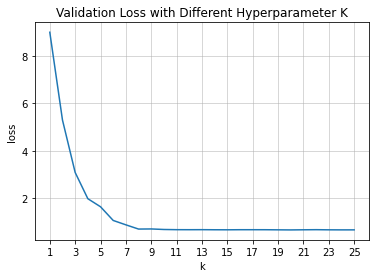

In [ ]:
plt.title('Validation Loss with Different Hyperparameter K')
plt.plot(vanilla_knn_diab_loss_list)

plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('k')
plt.xticks(range(0, MAX_K, 2), range(MIN_K, MAX_K+1, 2))
plt.show()

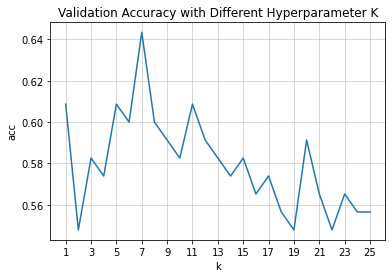

In [ ]:
plt.title('Validation Accuracy with Different Hyperparameter K')
plt.plot(vanilla_knn_diab_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('k')
plt.xticks(range(0, MAX_K, 2), range(MIN_K, MAX_K+1, 2))
plt.show()

In [ ]:
y_prob, _ = best_vanilla_knn_diab_model.predict(x_diab_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_diab_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_diab_test)
print("AUPRC: {}".format(pr))

x1 shape: (1, 460, 19), x2 shape: (576, 1, 19)
Loss: 0.6367544101022296
Accuracy: 0.6319444444444444
AUROC: 0.6927394257898114
AUPRC: 0.7306547637256606


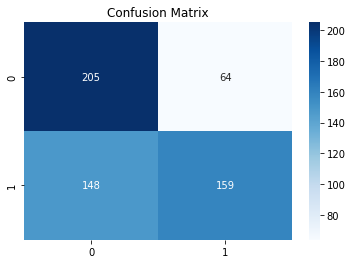

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_diab_test)

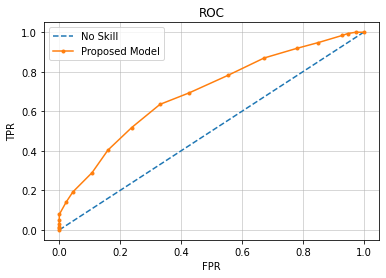

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_diab_test)

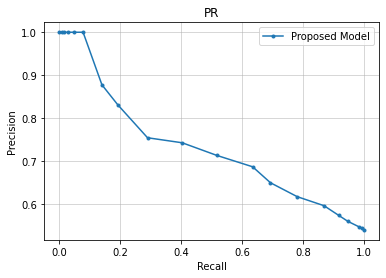

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_diab_test)

x1 shape: (1, 50, 2), x2 shape: (62500, 1, 2)


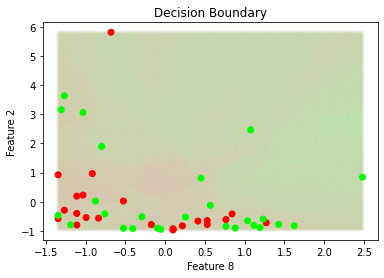

In [ ]:
# Choose two features
diab_y = y_diab_train[:50]
diab_x = x_diab_train[:50,[2,8]]

x0v = np.linspace(np.min(diab_x[:,0]), np.max(diab_x[:,0]), 250)
x1v = np.linspace(np.min(diab_x[:,1]), np.max(diab_x[:,1]), 250)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

diab_knn = KNN(K=best_vanilla_knn_diab_k, dist_fn=EUCLIDEAN)
y_all, _ = diab_knn.fit(diab_x, diab_y).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((diab_y.shape[0], 3))
y_train_prob[np.arange(diab_y.shape[0]), diab_y] = 1

plt.scatter(diab_x[:,0], diab_x[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 2')
plt.xlabel('Feature 8')
plt.title("Decision Boundary")
plt.show()

##### Vanilla KNN (Distance: Manhattan)

In [ ]:
best_vanilla_knn_diab_loss = float('inf')
best_vanilla_knn_diab_k = None
best_vanilla_knn_diab_model = None

vanilla_knn_diab_loss_list = [] # Loss on validation set
vanilla_knn_diab_acc_list = [] # Accuracy on validation set
 
for k in range(MIN_K, MAX_K + 1):

    vanilla_knn = KNN(K=k, dist_fn=MANHATTAN)
    y_prob, _ = vanilla_knn.fit(x_diab_train, y_diab_train).predict(x_diab_val)
    
    print("K: {}, y prob: {}".format(k, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_val)
    vanilla_knn_diab_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_val)
    vanilla_knn_diab_acc_list.append(acc)

    print("K: {}, Validation loss: {}, acc: {}".format(k, loss, acc))

    if loss < best_vanilla_knn_diab_loss:
        best_vanilla_knn_diab_loss = loss
        best_vanilla_knn_diab_k = k
        best_vanilla_knn_diab_model = vanilla_knn

print("Best loss: {}".format(best_vanilla_knn_diab_loss))
print("Best K: {}".format(best_vanilla_knn_diab_k))

x1 shape: (1, 460, 19), x2 shape: (115, 1, 19)
K: 1, y prob: [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1

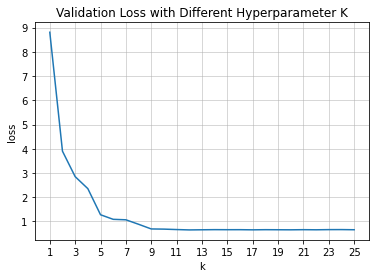

In [ ]:
plt.title('Validation Loss with Different Hyperparameter K')
plt.plot(vanilla_knn_diab_loss_list)
plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('k')
plt.xticks(range(0, MAX_K, 2), range(MIN_K, MAX_K+1, 2))
plt.show()

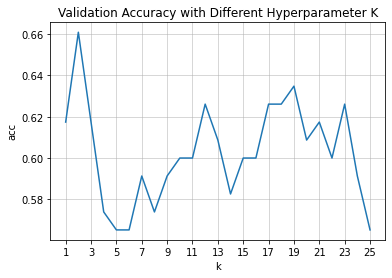

In [ ]:
plt.title('Validation Accuracy with Different Hyperparameter K')
plt.plot(vanilla_knn_diab_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('k')
plt.xticks(range(0, MAX_K, 2), range(MIN_K, MAX_K+1, 2))
plt.show()

In [ ]:
y_prob, _ = best_vanilla_knn_diab_model.predict(x_diab_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_diab_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_diab_test)
print("AUPRC: {}".format(pr))

x1 shape: (1, 460, 19), x2 shape: (576, 1, 19)
Loss: 0.7145812119522394
Accuracy: 0.6215277777777778
AUROC: 0.697655691849412
AUPRC: 0.7264189852771505


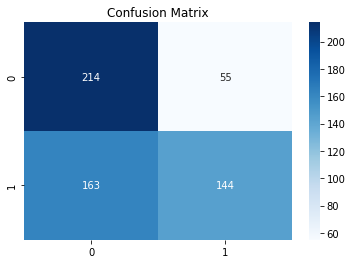

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_diab_test)

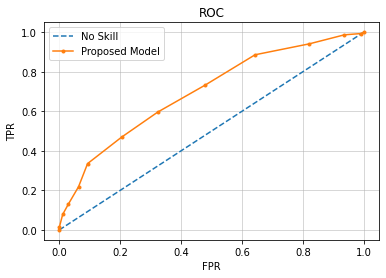

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_diab_test)

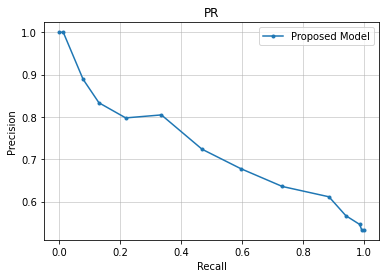

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_diab_test)

x1 shape: (1, 50, 2), x2 shape: (62500, 1, 2)


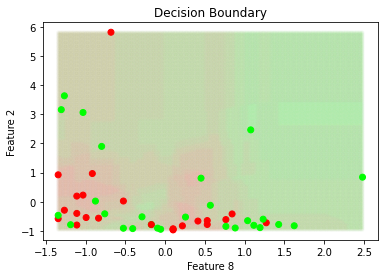

In [ ]:
# Choose two features
diab_y = y_diab_train[:50]
diab_x = x_diab_train[:50,[2,8]]

x0v = np.linspace(np.min(diab_x[:,0]), np.max(diab_x[:,0]), 250)
x1v = np.linspace(np.min(diab_x[:,1]), np.max(diab_x[:,1]), 250)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

diab_knn = KNN(K=best_vanilla_knn_diab_k, dist_fn=MANHATTAN)
y_all, _ = diab_knn.fit(diab_x, diab_y).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((diab_y.shape[0], 3))
y_train_prob[np.arange(diab_y.shape[0]), diab_y] = 1

plt.scatter(diab_x[:,0], diab_x[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 2')
plt.xlabel('Feature 8')
plt.title("Decision Boundary")
plt.show()

##### Weighted KNN (Distance: Euclidean)

In [ ]:
best_weighted_knn_diab_loss = float('inf')
best_weighted_knn_diab_k = None
best_weighted_knn_diab_model = None

weighted_knn_diab_loss_list = [] # Loss on validation set
weighted_knn_diab_acc_list = [] # Accuracy on validation set
 
for k in range(MIN_K, MAX_K + 1):

    weighted_knn = WeightedKNN(K=k, dist_fn=EUCLIDEAN)
    y_prob, _ = weighted_knn.fit(x_diab_train, y_diab_train).predict(x_diab_val)
    
    print("K: {}, y prob: {}".format(k, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_val)
    weighted_knn_diab_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_val)
    weighted_knn_diab_acc_list.append(acc)

    print("K: {}, Validation loss: {}, acc: {}".format(k, loss, acc))

    if loss < best_weighted_knn_diab_loss:
        best_weighted_knn_diab_loss = loss
        best_weighted_knn_diab_k = k
        best_weighted_knn_diab_model = weighted_knn

print("Best loss: {}".format(best_weighted_knn_diab_loss))
print("Best K: {}".format(best_weighted_knn_diab_k))

Streaming output truncated to the last 5000 lines.
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
K: 4, y prob: [[7.71175012e-01 2.28824988e-01]
 [4.75451009e-01 5.24548991e-01]
 [4.31891454e-01 5.68108546e-01]
 [2.29589097e-01 7.70410903e-01]
 [0.00000000e+00 1.00000000e+00]
 [4.64815010e-01 5.35184990e-01]
 [4.82723899e-01 5.17276101e-01]
 [3.41550512e-01 6.58449488e-01]
 [0.00000000e+00 1.00000000e+00]
 [2.40889221e-01 7.59110779e-01]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [2.95699126e-01 7.04300874e-01]
 [4.69722160e-01 5.30277840e-01]
 [2.33087855e-01 7.66912145e-01]
 [7.30959718e-01 2.69040282e-01]
 [4.96670975e-01 5.03329025e-01]
 [7.48750124e-01 2.51249876e-01]
 [2.87341323e-01 7.12658677e-01]
 [4.14970299e-01 5.85029701e-01]
 [5.14157130e-01 4.85842870e-01]
 [5.44233939e-01 4.55766061e-01]

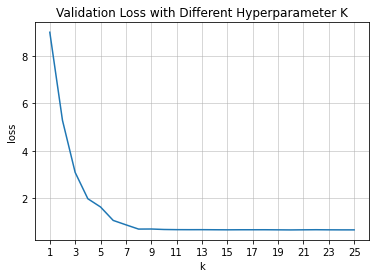

In [ ]:
plt.title('Validation Loss with Different Hyperparameter K')
plt.plot(weighted_knn_diab_loss_list)
plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('k')
plt.xticks(range(0, MAX_K, 2), range(MIN_K, MAX_K+1, 2))
plt.show()

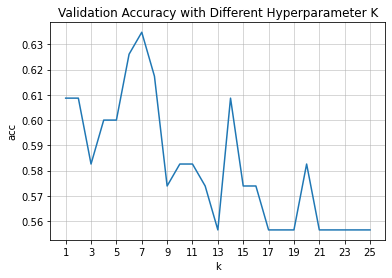

In [ ]:
plt.title('Validation Accuracy with Different Hyperparameter K')
plt.plot(weighted_knn_diab_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('k')
plt.xticks(range(0, MAX_K, 2), range(MIN_K, MAX_K+1, 2))
plt.show()

In [ ]:
y_prob, _ = best_weighted_knn_diab_model.predict(x_diab_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_diab_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_diab_test)
print("AUPRC: {}".format(pr))

x1 shape: (1, 460, 19), x2 shape: (576, 1, 19)
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999999
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999999
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of prob

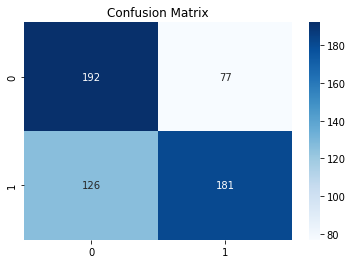

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_diab_test)

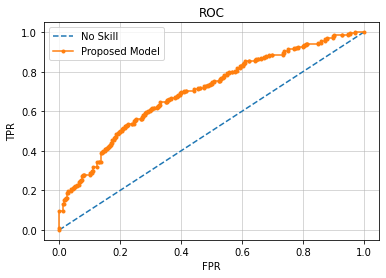

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_diab_test)

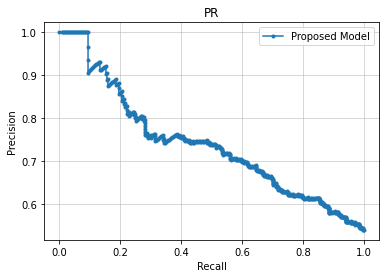

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_diab_test)

Streaming output truncated to the last 5000 lines.
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999998
Sum of probs: 1.0000000000000002
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999998
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999999
Sum of 

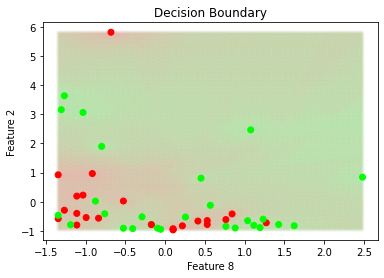

In [ ]:
# Choose two features
diab_y = y_diab_train[:50]
diab_x = x_diab_train[:50,[2,8]]

x0v = np.linspace(np.min(diab_x[:,0]), np.max(diab_x[:,0]), 250)
x1v = np.linspace(np.min(diab_x[:,1]), np.max(diab_x[:,1]), 250)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

diab_knn = WeightedKNN(K=best_weighted_knn_diab_k, dist_fn=EUCLIDEAN)
y_all, _ = diab_knn.fit(diab_x, diab_y).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((diab_y.shape[0], 3))
y_train_prob[np.arange(diab_y.shape[0]), diab_y] = 1

plt.scatter(diab_x[:,0], diab_x[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 2')
plt.xlabel('Feature 8')
plt.title("Decision Boundary")
plt.show()

##### Weighted KNN (Distance: Mahattan)

In [ ]:
best_weighted_knn_diab_loss = float('inf')
best_weighted_knn_diab_k = None
best_weighted_knn_diab_model = None

weighted_knn_diab_loss_list = [] # Loss on validation set
weighted_knn_diab_acc_list = [] # Accuracy on validation set
 
for k in range(MIN_K, MAX_K + 1):

    weighted_knn = WeightedKNN(K=k, dist_fn=MANHATTAN)
    y_prob, _ = weighted_knn.fit(x_diab_train, y_diab_train).predict(x_diab_val)
    
    print("K: {}, y prob: {}".format(k, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_val)
    weighted_knn_diab_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_val)
    weighted_knn_diab_acc_list.append(acc)

    print("K: {}, Validation loss: {}, acc: {}".format(k, loss, acc))

    if loss < best_weighted_knn_diab_loss:
        best_weighted_knn_diab_loss = loss
        best_weighted_knn_diab_k = k
        best_weighted_knn_diab_model = weighted_knn

print("Best loss: {}".format(best_weighted_knn_diab_loss))
print("Best K: {}".format(best_weighted_knn_diab_k))

Streaming output truncated to the last 5000 lines.
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
K: 4, y prob: [[1.00000000e+00 0.00000000e+00]
 [7.48948937e-01 2.51051063e-01]
 [5.48166509e-01 4.51833491e-01]
 [2.01063356e-01 7.98936644e-01]
 [0.00000000e+00 1.00000000e+00]
 [4.75672223e-01 5.24327777e-01]
 [2.45401688e-01 7.54598312e-01]
 [3.81388087e-01 6.18611913e-01]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [3.09204371e-01 6.90795629e-01]
 [7.11917579e-01 2.88082421e-01]
 [2.17801781e-01 7.82198219e-01]
 [4.73792701e-01 5.26207299e-01]
 [4.55773799e-01 5.44226201e-01]
 [7.65116247e-01 2.34883753e-01]
 [2.54848002e-01 7.45151998e-01]
 [2.04537909e-01 7.95462091e-01]
 [7.51400316e-01 2.48599684e-01]
 [7.13019492e-01 2.86980508e-01]
 [1.85701562e-

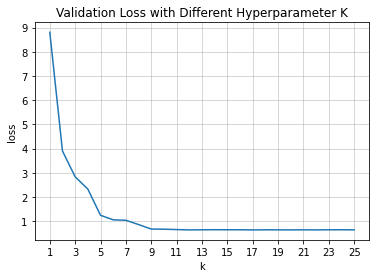

In [ ]:
plt.title('Validation Loss with Different Hyperparameter K')
plt.plot(weighted_knn_diab_loss_list)
plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('k')
plt.xticks(range(0, MAX_K, 2), range(MIN_K, MAX_K+1, 2))
plt.show()

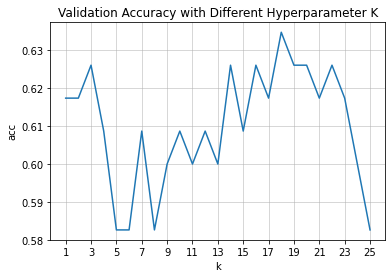

In [ ]:
plt.title('Validation Accuracy with Different Hyperparameter K')
plt.plot(weighted_knn_diab_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('k')
plt.xticks(range(0, MAX_K, 2), range(MIN_K, MAX_K+1, 2))
plt.show()

In [ ]:
y_prob, _ = best_weighted_knn_diab_model.predict(x_diab_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_diab_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_diab_test)
print("AUPRC: {}".format(pr))

x1 shape: (1, 460, 19), x2 shape: (576, 1, 19)
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 0.9999999999999997
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0000000000000002
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 1.0

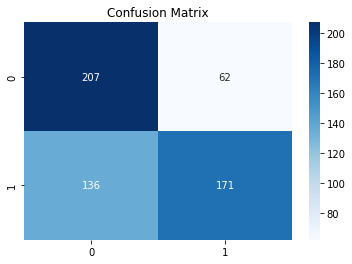

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_diab_test)

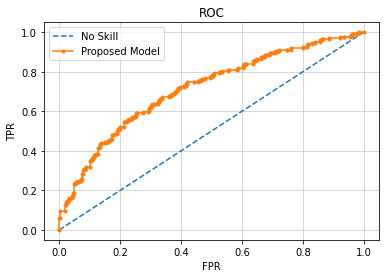

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_diab_test)

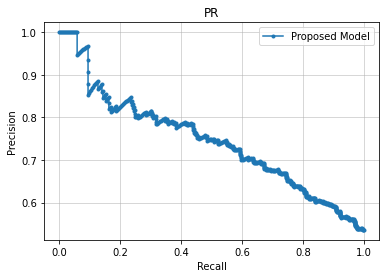

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_diab_test)

Streaming output truncated to the last 5000 lines.
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 0.9999999999999998
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999999
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 0.9999999999999998
Sum of probs: 0.9999999999999998
Sum of probs: 0.9999999999999999
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0
Sum of probs: 1.0000000000000002
Sum of probs: 0.9999999999999998
Sum of probs: 1.0
Sum of probs:

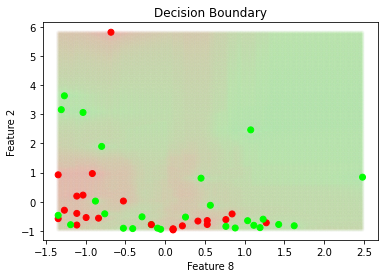

In [ ]:
# Choose two features
diab_y = y_diab_train[:50]
diab_x = x_diab_train[:50,[2,8]]

x0v = np.linspace(np.min(diab_x[:,0]), np.max(diab_x[:,0]), 250)
x1v = np.linspace(np.min(diab_x[:,1]), np.max(diab_x[:,1]), 250)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

diab_knn = WeightedKNN(K=best_weighted_knn_diab_k, dist_fn=MANHATTAN)
y_all, _ = diab_knn.fit(diab_x, diab_y).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((diab_y.shape[0], 3))
y_train_prob[np.arange(diab_y.shape[0]), diab_y] = 1

plt.scatter(diab_x[:,0], diab_x[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 2')
plt.xlabel('Feature 8')
plt.title("Decision Boundary")
plt.show()

## DT

###Hepatis

####With Misclassification Cost Function

In [ ]:
best_dt_hepa_loss = float('inf')
best_dt_hepa_d = None
best_dt = None

dt_hepa_loss_list = [] # Loss on validation set
dt_hepa_acc_list = [] # Accuracy on validation set

for d in range(MIN_K, MAX_K + 1):

    dt = DecisionTree(max_depth = d)
    y_prob = dt.fit(x_hepa_train, y_hepa_train).predict(x_hepa_val)
    
    print("max_depth: {}, y prob: {}".format(d, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_hepa_val)
    dt_hepa_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_hepa_val)
    dt_hepa_acc_list.append(acc)

    print("max_depth: {}, Validation loss: {}, acc: {}".format(d, loss, acc))

    if loss < best_dt_hepa_loss:
        best_dt_hepa_loss = loss
        best_dt_hepa_d = d
        best_dt = dt

print("Best loss: {}".format(best_dt_hepa_loss))
print("Best max_depth: {}".format(best_dt_hepa_d))

max_depth: 1, y prob: [[0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [1.         0.        ]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]]
max_depth: 1, Validation loss: 3.241827899208557, acc: 0.75
max_depth: 2, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 2, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 3, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 3, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 4, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 4, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 5, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 5, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 6, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
ma

In [ ]:
feature_importance = best_dt.get_feature_importance()
print(feature_importance)

Feature importance: 53
[53]


####With Entropy Cost Function

In [ ]:
best_dt_hepa_loss = float('inf')
best_dt_hepa_d = None
best_dt = None

dt_hepa_loss_list = [] # Loss on validation set
dt_hepa_acc_list = [] # Accuracy on validation set

for d in range(MIN_K, MAX_K + 1):

    dt = DecisionTree(max_depth = d, cost_fn = cost_entropy)
    y_prob = dt.fit(x_hepa_train, y_hepa_train).predict(x_hepa_val)
    
    print("max_depth: {}, y prob: {}".format(d, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_hepa_val)
    dt_hepa_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_hepa_val)
    dt_hepa_acc_list.append(acc)

    print("max_depth: {}, Validation loss: {}, acc: {}".format(d, loss, acc))

    if loss < best_dt_hepa_loss:
        best_dt_hepa_loss = loss
        best_dt_hepa_d = d
        best_dt = dt

print("Best loss: {}".format(best_dt_hepa_loss))
print("Best max_depth: {}".format(best_dt_hepa_d))

max_depth: 1, y prob: [[0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [1.         0.        ]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]]
max_depth: 1, Validation loss: 3.241827899208557, acc: 0.75
max_depth: 2, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 2, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 3, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 3, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 4, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 4, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 5, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 5, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 6, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
ma

In [ ]:
feature_importance = best_dt.get_feature_importance()
print(feature_importance)

Feature importance: 53
[53]


####With Gini Index Cost Function

In [ ]:
best_dt_hepa_loss = float('inf')
best_dt_hepa_d = None
best_dt = None

dt_hepa_loss_list = [] # Loss on validation set
dt_hepa_acc_list = [] # Accuracy on validation set

for d in range(MIN_K, MAX_K + 1):

    dt = DecisionTree(max_depth = d, cost_fn = cost_gini_index)
    y_prob = dt.fit(x_hepa_train, y_hepa_train).predict(x_hepa_val)
    
    print("max_depth: {}, y prob: {}".format(d, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_hepa_val)
    dt_hepa_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_hepa_val)
    dt_hepa_acc_list.append(acc)

    print("max_depth: {}, Validation loss: {}, acc: {}".format(d, loss, acc))

    if loss < best_dt_hepa_loss:
        best_dt_hepa_loss = loss
        best_dt_hepa_d = d
        best_dt = dt

print("Best loss: {}".format(best_dt_hepa_loss))
print("Best max_depth: {}".format(best_dt_hepa_d))

max_depth: 1, y prob: [[0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]
 [1.         0.        ]
 [0.18181818 0.81818182]
 [0.18181818 0.81818182]]
max_depth: 1, Validation loss: 3.241827899208557, acc: 0.75
max_depth: 2, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 2, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 3, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 3, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 4, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 4, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 5, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
max_depth: 5, Validation loss: 5.756462732410115, acc: 0.75
max_depth: 6, y prob: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
ma

In [ ]:
feature_importance = best_dt.get_feature_importance()
print(feature_importance)

Feature importance: 53
[53]


From the above experiment, we find that the results are the same for all cost functions. So the following plots and experiments are for all cost functions.

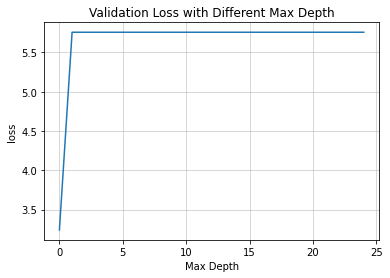

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.title('Validation Loss with Different Max Depth')
plt.plot(dt_hepa_loss_list)
plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('Max Depth')
plt.show()


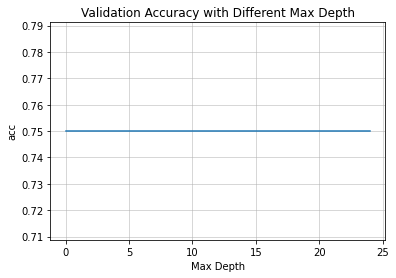

In [ ]:
plt.title('Validation Accuracy with Different Max Depth')
plt.plot(dt_hepa_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('Max Depth')
plt.show()

In [ ]:
y_prob = best_dt.predict(x_hepa_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_hepa_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_hepa_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_hepa_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_hepa_test)
print("AUPRC: {}".format(pr))

Loss: 0.906657638681797
Accuracy: 0.875
AUROC: 0.6991341991341992
AUPRC: 0.9417929292929293


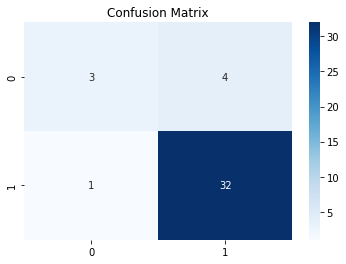

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_hepa_test)

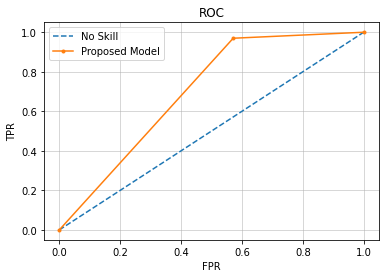

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_hepa_test)

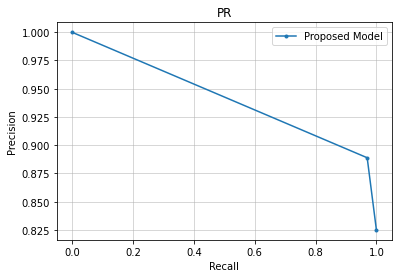

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_hepa_test)

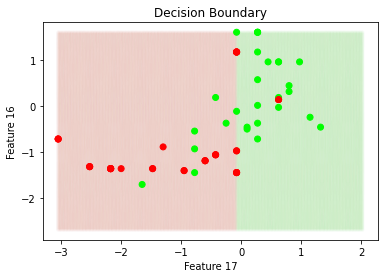

In [ ]:
# Hepatitis feature before one-hot encoding
hepa_x, hepa_y = hepa_dataset.features, hepa_dataset.labels

# Choose two features
hepa_x = hepa_x[:,[16,17]]

# Standardization
scaler = StandardScaler()
hepa_x = scaler.fit_transform(hepa_x)

# Over sampling
over_sampler = RandomOverSampler(sampling_strategy='minority')
hepa_x, hepa_y = over_sampler.fit_resample(hepa_x, hepa_y)

hepa_y -= 1
hepa_y = hepa_y.astype(int)

# Train test split
hepa_x_train, _, hepa_y_train, _ = train_test_split(hepa_x, hepa_y, 
                                                    test_size=TEST_SIZE_DEFAULT,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE_DEFAULT)

x0v = np.linspace(np.min(hepa_x[:,0]), np.max(hepa_x[:,0]), 200)
x1v = np.linspace(np.min(hepa_x[:,1]), np.max(hepa_x[:,1]), 200)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

hepa_dt = DecisionTree(max_depth = 1)
y_all = hepa_dt.fit(hepa_x_train, hepa_y_train).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((hepa_y_train.shape[0], 3))
y_train_prob[np.arange(hepa_y_train.shape[0]), hepa_y_train] = 1

plt.scatter(hepa_x_train[:,0], hepa_x_train[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 16')
plt.xlabel('Feature 17')
plt.title("Decision Boundary")
plt.show()

###Diabetis

####With Misclassification Cost Function

In [ ]:
best_dt_diab_loss = float('inf')
best_dt_diab_d = None
best_dt = None

dt_diab_loss_list = [] # Loss on validation set
dt_diab_acc_list = [] # Accuracy on validation set

for d in range(MIN_K, MAX_K + 1):

    dt = DecisionTree(max_depth = d)
    y_prob = dt.fit(x_diab_train, y_diab_train).predict(x_diab_val)
    
    print("max_depth: {}, y prob: {}".format(d, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_val)
    dt_diab_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_val)
    dt_diab_acc_list.append(acc)

    print("max_depth: {}, Validation loss: {}, acc: {}".format(d, loss, acc))

    if loss < best_dt_hepa_loss:
        best_dt_diab_loss = loss
        best_dt_diab_d = d
        best_dt = dt

print("Best loss: {}".format(best_dt_diab_loss))
print("Best max_depth: {}".format(best_dt_diab_d))

max_depth: 1, y prob: [[0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0.39879154 0.60120846]
 [0.65116279 0.34883721]
 [0.65116279 0.34883721]
 [0.39879154 0.60120846]
 [0

In [ ]:
feature_importance = best_dt.get_feature_importance()
print(feature_importance[:3])

Feature importance: 2
Feature importance: 8
Feature importance: 9
Feature importance: 13
Feature importance: 12
Feature importance: 16
Feature importance: 16
Feature importance: 17
Feature importance: 10
Feature importance: 2
Feature importance: 4
Feature importance: 2
Feature importance: 2
Feature importance: 8
Feature importance: 8
Feature importance: 4
Feature importance: 9
Feature importance: 1
Feature importance: 1
Feature importance: 1
Feature importance: 1
Feature importance: 1
Feature importance: 1
Feature importance: 16
Feature importance: 10
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 4
Feature importance: 15
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 0
Feature importance: 7
Feature importance: 3
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 0
F

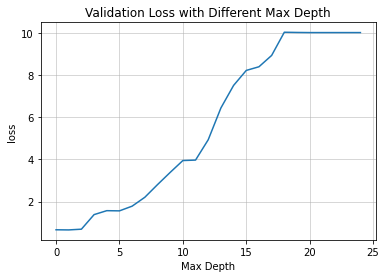

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.title('Validation Loss with Different Max Depth')
plt.plot(dt_diab_loss_list)
plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('Max Depth')
plt.show()

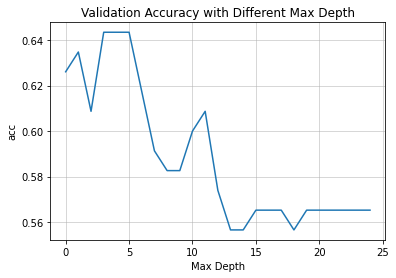

In [ ]:
plt.title('Validation Accuracy with Different Max Depth')
plt.plot(dt_diab_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('Max Depth')
plt.show()

In [ ]:
y_prob = best_dt.predict(x_diab_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_diab_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_diab_test)
print("AUPRC: {}".format(pr))

Loss: 2.668396146186283
Accuracy: 0.625
AUROC: 0.637964229926256
AUPRC: 0.653246881186989


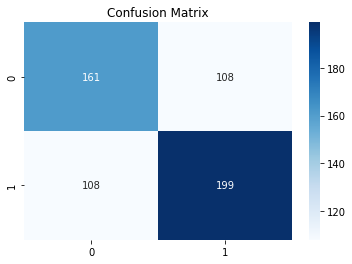

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_diab_test)

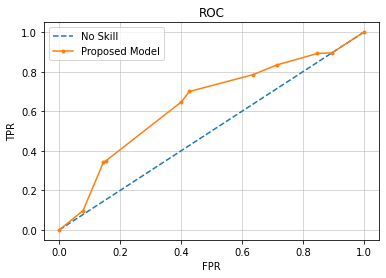

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_diab_test)

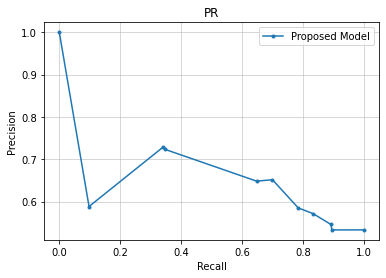

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_diab_test)

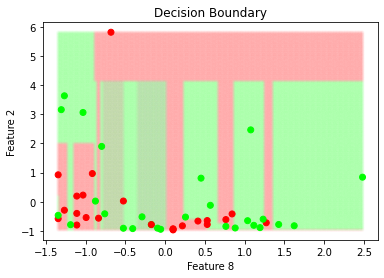

In [ ]:
# Choose two features
diab_y = y_diab_train[:50]
diab_x = x_diab_train[:50,[2,8]]

x0v = np.linspace(np.min(diab_x[:,0]), np.max(diab_x[:,0]), 250)
x1v = np.linspace(np.min(diab_x[:,1]), np.max(diab_x[:,1]), 250)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

diab_dt = DecisionTree(max_depth=9)
y_all = diab_dt.fit(diab_x, diab_y).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((diab_y.shape[0], 3))
y_train_prob[np.arange(diab_y.shape[0]), diab_y] = 1

plt.scatter(diab_x[:,0], diab_x[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 2')
plt.xlabel('Feature 8')
plt.title("Decision Boundary")
plt.show()

####With Entropy Cost Function

In [ ]:
best_dt_diab_loss = float('inf')
best_dt_diab_d = None
best_dt = None

dt_diab_loss_list = [] # Loss on validation set
dt_diab_acc_list = [] # Accuracy on validation set

for d in range(MIN_K, MAX_K + 1):

    dt = DecisionTree(max_depth = d, cost_fn = cost_entropy)
    y_prob = dt.fit(x_diab_train, y_diab_train).predict(x_diab_val)
    
    print("max_depth: {}, y prob: {}".format(d, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_val)
    dt_diab_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_val)
    dt_diab_acc_list.append(acc)

    print("max_depth: {}, Validation loss: {}, acc: {}".format(d, loss, acc))

    if loss < best_dt_hepa_loss:
        best_dt_diab_loss = loss
        best_dt_diab_d = d
        best_dt = dt

print("Best loss: {}".format(best_dt_diab_loss))
print("Best max_depth: {}".format(best_dt_diab_d))

max_depth: 1, y prob: [[0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.02380952 0.97619048]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.02380952 0.97619048]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.02380952 0.97619048]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.02380952 0.97619048]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0.51435407 0.48564593]
 [0

In [ ]:
feature_importance = best_dt.get_feature_importance()
print(feature_importance[:3])

Feature importance: 14
Feature importance: 2
Feature importance: 16
Feature importance: 8
Feature importance: 6
Feature importance: 2
Feature importance: 1
Feature importance: 2
Feature importance: 2
Feature importance: 1
Feature importance: 13
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 10
Feature importance: 6
Feature importance: 1
Feature importance: 8
Feature importance: 2
Feature importance: 2
Feature importance: 8
Feature importance: 11
Feature importance: 2
Feature importance: 2
Feature importance: 16
Feature importance: 1
Feature importance: 16
Feature importance: 9
Feature importance: 2
Feature importance: 14
Feature importance: 2
Feature importance: 2
Feature importance: 3
Feature importance: 2
Feature importance: 8
Feature importance: 2
Feature importance: 2
Feature importance: 17
Feature importance: 2
[14, 2, 16]


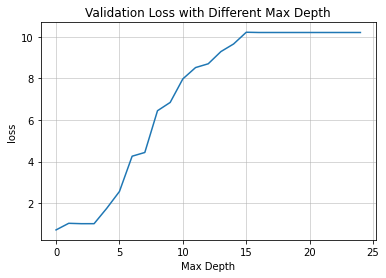

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.title('Validation Loss with Different Max Depth')
plt.plot(dt_diab_loss_list)
plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('Max Depth')
plt.show()

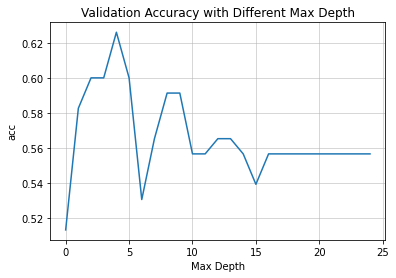

In [ ]:
plt.title('Validation Accuracy with Different Max Depth')
plt.plot(dt_diab_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('Max Depth')
plt.show()

In [ ]:
y_prob = best_dt.predict(x_diab_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_diab_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_diab_test)
print("AUPRC: {}".format(pr))

Loss: 2.080129814216475
Accuracy: 0.6180555555555556
AUROC: 0.6658573798481527
AUPRC: 0.7255015706442606


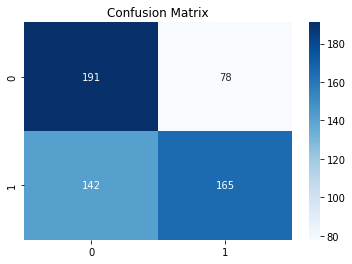

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_diab_test)

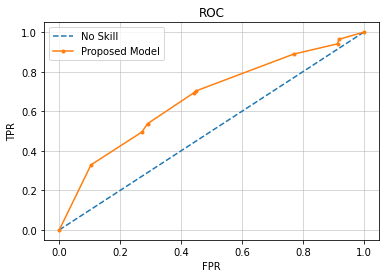

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_diab_test)

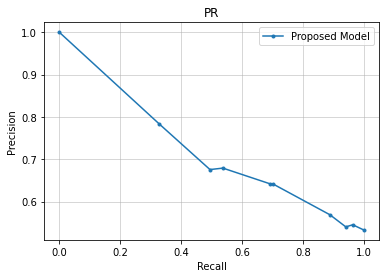

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_diab_test)

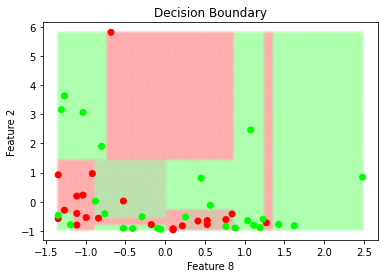

In [ ]:
# Choose two features
diab_y = y_diab_train[:50]
diab_x = x_diab_train[:50,[2,8]]

x0v = np.linspace(np.min(diab_x[:,0]), np.max(diab_x[:,0]), 250)
x1v = np.linspace(np.min(diab_x[:,1]), np.max(diab_x[:,1]), 250)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

diab_dt = DecisionTree(max_depth=6, cost_fn=cost_entropy)
y_all = diab_dt.fit(diab_x, diab_y).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((diab_y.shape[0], 3))
y_train_prob[np.arange(diab_y.shape[0]), diab_y] = 1

plt.scatter(diab_x[:,0], diab_x[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 2')
plt.xlabel('Feature 8')
plt.title("Decision Boundary")
plt.show()

####With Gini Index Cost Function

In [ ]:
best_dt_diab_loss = float('inf')
best_dt_diab_d = None
best_dt = None

dt_diab_loss_list = [] # Loss on validation set
dt_diab_acc_list = [] # Accuracy on validation set

for d in range(MIN_K, MAX_K + 1):

    dt = DecisionTree(max_depth = d, cost_fn = cost_gini_index)
    y_prob = dt.fit(x_diab_train, y_diab_train).predict(x_diab_val)
    
    print("max_depth: {}, y prob: {}".format(d, y_prob))
    
    y_prob = y_prob[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_val)
    dt_diab_loss_list.append(loss)

    acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_val)
    dt_diab_acc_list.append(acc)

    print("max_depth: {}, Validation loss: {}, acc: {}".format(d, loss, acc))

    if loss < best_dt_hepa_loss:
        best_dt_diab_loss = loss
        best_dt_diab_d = d
        best_dt = dt

print("Best loss: {}".format(best_dt_diab_loss))
print("Best max_depth: {}".format(best_dt_diab_d))

max_depth: 1, y prob: [[0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.15       0.85      ]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.15       0.85      ]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.15       0.85      ]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.15       0.85      ]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.15       0.85      ]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.15       0.85      ]
 [0.53684211 0.46315789]
 [0.15       0.85      ]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.15       0.85      ]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0.53684211 0.46315789]
 [0

In [ ]:
feature_importance = best_dt.get_feature_importance()
print(feature_importance[:3])

Feature importance: 14
Feature importance: 2
Feature importance: 14
Feature importance: 8
Feature importance: 6
Feature importance: 9
Feature importance: 16
Feature importance: 1
Feature importance: 2
Feature importance: 11
Feature importance: 2
Feature importance: 8
Feature importance: 14
Feature importance: 2
Feature importance: 1
Feature importance: 11
Feature importance: 10
Feature importance: 1
Feature importance: 8
Feature importance: 2
Feature importance: 7
Feature importance: 8
Feature importance: 1
Feature importance: 17
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 17
Feature importance: 10
Feature importance: 16
Feature importance: 8
Feature importance: 2
Feature importance: 14
Feature importance: 10
Feature importance: 1
Feature importance: 2
Feature importance: 2
Feature importance: 1
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance: 2
Feature importance:

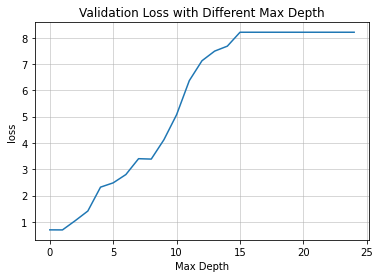

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.title('Validation Loss with Different Max Depth')
plt.plot(dt_diab_loss_list)
plt.grid(linewidth=0.5)
plt.ylabel('loss')
plt.xlabel('Max Depth')
plt.show()

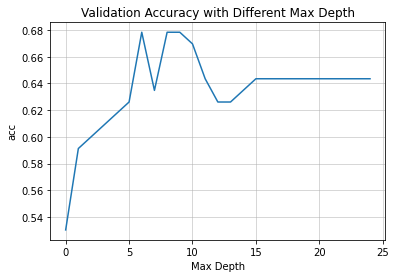

In [ ]:
plt.title('Validation Accuracy with Different Max Depth')
plt.plot(dt_diab_acc_list)
plt.grid(linewidth=0.5)
plt.ylabel('acc')
plt.xlabel('Max Depth')
plt.show()

In [ ]:
y_prob = best_dt.predict(x_diab_test)
y_prob = y_prob[:,1]
y_pred = (y_prob > 0.5).astype(int)

loss = EvaluationUtils.calculate_bce_loss(y_prob, y_diab_test)
print("Loss: {}".format(loss))

acc = EvaluationUtils.calculate_accuracy(y_pred, y_diab_test)
print("Accuracy: {}".format(acc))

roc = EvaluationUtils.calculate_roc_auc(y_prob, y_diab_test)
print("AUROC: {}".format(roc))

pr = EvaluationUtils.calculate_pr_auc(y_prob, y_diab_test)
print("AUPRC: {}".format(pr))

Loss: 4.1415556993143
Accuracy: 0.6059027777777778
AUROC: 0.6108339488756765
AUPRC: 0.7073843306986238


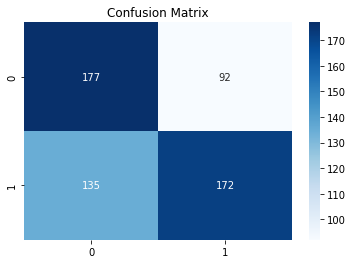

In [ ]:
EvaluationUtils.plot_confusion_matrix(y_pred, y_diab_test)

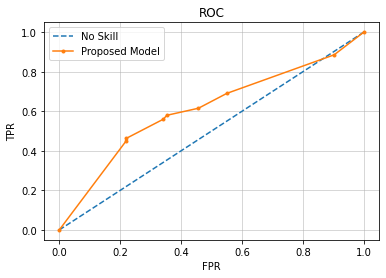

In [ ]:
EvaluationUtils.plot_roc_curve(y_prob, y_diab_test)

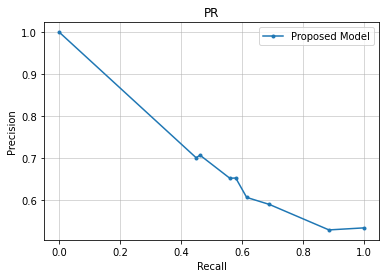

In [ ]:
EvaluationUtils.plot_pr_curve(y_prob, y_diab_test)

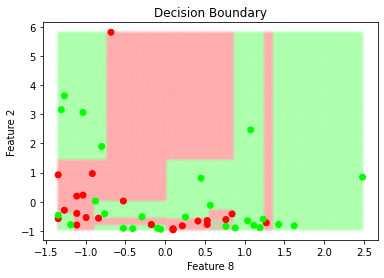

In [ ]:
# Choose two features
diab_y = y_diab_train[:50]
diab_x = x_diab_train[:50,[2,8]]

x0v = np.linspace(np.min(diab_x[:,0]), np.max(diab_x[:,0]), 250)
x1v = np.linspace(np.min(diab_x[:,1]), np.max(diab_x[:,1]), 250)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

diab_dt = DecisionTree(max_depth=7, cost_fn=cost_gini_index)
y_all = diab_dt.fit(diab_x, diab_y).predict(x_all)
y_all = np.append(y_all, np.zeros((y_all.shape[0],1)), axis=1)

y_train_prob = np.zeros((diab_y.shape[0], 3))
y_train_prob[np.arange(diab_y.shape[0]), diab_y] = 1

plt.scatter(diab_x[:,0], diab_x[:,1], c=y_train_prob, marker='o', alpha=1, zorder=2)
plt.scatter(x_all[:,0], x_all[:,1], c=y_all, marker='.', alpha=0.02, zorder=1)
plt.ylabel('Feature 2')
plt.xlabel('Feature 8')
plt.title("Decision Boundary")
plt.show()